# EDA with short answer questions.

Looks good! A simple SVM can seperate 2 different questions with very high accuracy. Time to get notebook into a nice format for working with a given subset of the questions (2-all) and control at least a few parameters (max_features, SVM's C) to demonstrate overfitting issues. Oh, and plot it all. Perhaps after PCA?

In [354]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.cm as cm

First, creating a dataset with all the short answers for every question prompt:

In [355]:
df_full=pd.read_csv('train.csv')

Next, this cell looks at a subset of the essay prompts, creates ngrams and a count matrix, splits the data into train/test sets, and trains an SVM. I maybe should break that into a couple defns

In [594]:
question_subset=[7,8];
ngram_range=(1,5);
max_features=20;
train_column='EssayText'

In [595]:
df_q=df_full.loc[(df_full.loc[:,'EssaySet'].isin(question_subset)),:]
df_q.reset_index(inplace=True)
del df_q['index']
baseline=(df_q.loc[:,'EssaySet'].value_counts().values/len(df_q)).max();
print('Single solution baseline:', np.round(baseline*100,2),'percent correct')

Single solution baseline: 50.0 percent correct


## Creating tfidf matrix

In [596]:
def tfidf(df_q, ngram_range, max_features):
    tfidf_vectorizer = TfidfVectorizer(min_df=1, 
                                       max_df=.9, 
                                       ngram_range=ngram_range, 
                                       max_features=max_features,
                                       analyzer = 'word',stop_words='english')
    X= tfidf_vectorizer.fit_transform(df_q[train_column].str.lower().values)
    df_vector=pd.DataFrame(X.todense())
    df_vector['label']=df_q['EssaySet']
    return df_vector

In [597]:
df_vector=tfidf(df_q,ngram_range, max_features)

C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [598]:
def train_test_split(df_vector):
    train_index=np.random.choice(df_vector.index,int(len(df_vector)*.8),replace=False);
    test_index=[i for i in df_vector.index if i not in train_index]
    return train_index, test_index

In [599]:
train_index, test_index=train_test_split(df_vector)

In [600]:
def SVM(df_vector, train_index, test_index):
    X_train=df_vector.iloc[train_index,:-1]
    Y_train=df_vector.loc[train_index,'label']
    X_test=df_vector.iloc[test_index,:-1]
    Y_test=df_vector.loc[test_index,'label']
    clf=svm.SVC()
    clf.fit(X_train,Y_train)
    scores = cross_val_score(clf, X_train, Y_train, cv=10)
    cv_mean=np.round(scores.mean()*100,2);
    cv_std=np.round(scores.std()*100,2)
    print('model score:',cv_mean,'+/-', cv_std)
    predictions=np.round(clf.score(X_test, Y_test)*100,2)
    print(predictions)
    return clf, cv_mean, cv_std, predictions

In [601]:
clf, sv_mean, cv_std, predictions=SVM(df_vector,train_index,test_index)

model score: 97.22 +/- 1.12
97.08


In [602]:
# mf=[1,10,50,100];
# cv_means=[];
# cv_stds=[];
# Pred=[];
# for max_features in mf:
#     df_vector=tfidf(df_q,ngram_range, max_features)
#     clf, cv_mean, cv_std, predictions=SVM(df_vector,train_index,test_index)
#     cv_means.append(cv_mean)
#     cv_stds.append(cv_std)
#     Pred.append(predictions)

In [603]:
# ax = plt.subplot(111)
# ax.errorbar(mf, cv_means, yerr=cv_stds, xerr=None)
# #ax.set_xscale("log", nonposx='clip')
# #plt.axhline(y=baseline*100)
# plt.show()

In [604]:
# Cs=[.0001, .001, .01, .1, 1,100,100000]
# Ss=[];
# errs=[];
# for c in Cs:
#     print(c)
#     clf.set_params(C=c)
#     X_train=df_vector.iloc[train_index,:-1].values
#     Y_train=df_vector.loc[train_index,'label'].values
#     clf.fit(X_train, Y_train)
#     scores = cross_val_score(clf, X_train, Y_train, cv=10)
#     print(scores.mean())
#     Ss.append(scores.mean())
#     errs.append(scores.std())

In [605]:
# ax = plt.subplot(111)
# ax.errorbar(Cs, Ss, yerr=errs, xerr=None)
# ax.set_xscale("log", nonposx='clip')
# plt.show()

In [606]:
from sklearn import decomposition

In [607]:
def pca(n):
    pca=decomposition.PCA(n_components=n)
    pca.fit(df_vector.iloc[:,:-1])
    X_pca=pca.transform(df_vector.iloc[:,:-1])
    df_temp=pd.DataFrame(X_pca);
    df_temp['label']=df_vector.iloc[:,-1];
    df_temp['prediction']=clf.predict(df_vector.iloc[:,:-1])
    return df_temp

In [608]:
df_temp=pca(10)

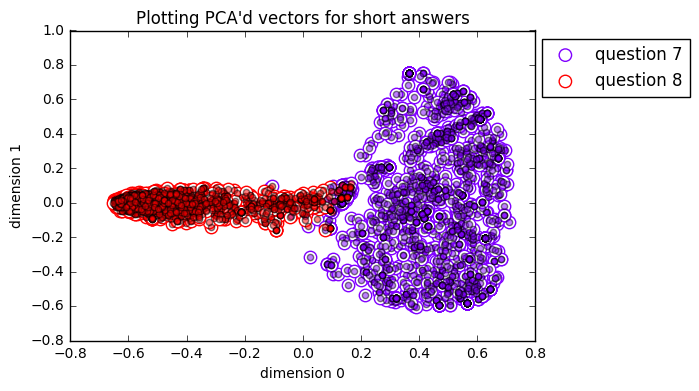

In [609]:
dim0=0;
dim1=1;
colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))
for q in question_subset:
    color=next(colors)
    plt.scatter(df_temp.loc[df_temp.loc[:,'prediction']==q,dim0],df_temp.loc[df_temp.loc[:,'prediction']==q,dim1],
                edgecolor=color,alpha=1, s=80, facecolor='white',label='question %s'%q);
#     plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
#                 edgecolor='black', c=color,alpha=.5, label='question %s'%q);
colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))
plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.35,1))
for q in question_subset:
    color=next(colors)
#     plt.scatter(df_temp.loc[df_temp.loc[:,'prediction']==q,dim0],df_temp.loc[df_temp.loc[:,'prediction']==q,dim1],
#                 edgecolor=color,alpha=1, s=80, facecolor='white',label='question %s'%q);
    plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
                edgecolor='black', c=color,alpha=.5);

plt.xlabel('dimension %s'%(dim0))
plt.ylabel('dimension %s'%(dim1))
plt.title("Plotting PCA'd vectors for short answers")
plt.show()

# LDA or k-means?

In [610]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [613]:
def LDA(text_column, n_features, n_components):
    #text_column='EssayText' #source of the text samples. Again, could use stemmed text.
    data_samples=df_q[text_column].str.lower().values
    n_samples = len(data_samples)
    #n_features = 300 #max number of n-grams to track. i.e. max length of vector representation of text samples. 
    #n_components = 3 #number of topics to group text into
    n_top_words = 10 #number of words to print out associated with each topic--to help analyst name topic

    #only using a count matrix here. So not normalized.
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=.05,
                                    max_features=n_features,ngram_range=(1,7),
                                    stop_words='english')

    tf = tf_vectorizer.fit_transform(data_samples)

    #setting up the LDA
    lda = LatentDirichletAllocation(n_topics=n_components,learning_method='batch')
    #using all text samples to fit lda. Could save subportion for testing fit later.
    lda.fit(tf)

    #getting the n-grams for the tf matrix for use when finding which n-grams are associated with which topic
    tf_feature_names = tf_vectorizer.get_feature_names()

    # #saving top topic for each text sample to the dataframe.
    return tf, lda, tf_feature_names

In [614]:
tf, lda, tf_names=LDA('EssayText', 300, 2)

In [615]:
pd.Series(np.argmax(lda.transform(tf),axis=1)).value_counts()

1    1800
0    1798
dtype: int64

In [616]:
len(df_q)

3598

In [617]:
df_temp['topics']=np.argmax(lda.transform(tf),axis=1)

In [618]:
df_temp['topic_conversion']=''
for t in sorted(df_temp.loc[:,'topics'].unique()):
    label_topic_conversion=df_temp.loc[df_temp.loc[:,'topics']==t,'label'].value_counts().index[0]
    df_temp.loc[df_temp.loc[:,'topics']==t,'topic_conversion']=label_topic_conversion

In [619]:
percent_correct=np.round((df_temp['label']==df_temp['topic_conversion']).sum()/len(df_temp)*100,2)
print(percent_correct)

96.97


In [620]:
# dim0=0;
# dim1=1;
# colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))
# #for q in sorted(df_temp.loc[:,'topic'].unique()):
# for q in question_subset:
#     color=next(colors)
#     plt.scatter(df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim0],df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim1],
#                 edgecolor=color,alpha=1, s=80, facecolor='white',label='topic %s'%q);
# #     plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
# #                 edgecolor='black', c=color,alpha=.5, label='question %s'%q);
# colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))

# for q in question_subset:
#     color=next(colors)
# #     plt.scatter(df_temp.loc[df_temp.loc[:,'prediction']==q,dim0],df_temp.loc[df_temp.loc[:,'prediction']==q,dim1],
# #                 edgecolor=color,alpha=1, s=80, facecolor='white',label='question %s'%q);
#     plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
#                 edgecolor='black', c=color,alpha=.5,label='question %s'%q);
# plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.35,1))
# plt.xlabel('dimension %s'%(dim0))
# plt.ylabel('dimension %s'%(dim1))
# plt.title("Plotting PCA'd vectors for short answers")
# plt.show()

In [621]:
def LDA_topic_words_and_count(x, tf_feature_names):
    df_names=pd.DataFrame(); #dataframe used to associated n-grams (tf_feature_names) with their weights in a topic.
    df_names['words']=tf_feature_names;
    df_names['scores']=lda.components_[x]
    #sorting df_names by scores to get n-grams most strongly associated with the given topic.
    top_words='|'.join(df_names.sort_values(by='scores',ascending=False)['words'][0:n_top_words])
    #count=(df['topic']==x).sum()
    return top_words

In [622]:
for x in range(0,2):
#x=0
    top_words=LDA_topic_words_and_count(x, tf_names)
    print("""LDA topic %s top words are: %s"""%(x,top_words))
    print(' ')

LDA topic 0 top words are: paul|mr|leonard|mr leonard|read|help|information|track|college|good
 
LDA topic 1 top words are: rose|aunt|anna|family|help|sister|trait|kolab|aunt kolab|like
 


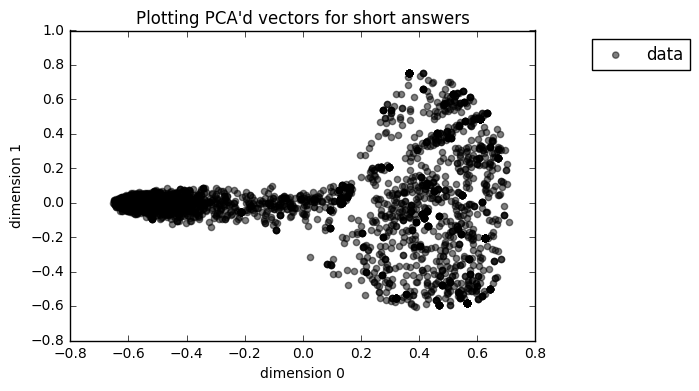

In [623]:
dim0=0;
dim1=1;
plt.scatter(df_temp.loc[:,dim0],df_temp.loc[:,dim1],
                c='black',alpha=.5,label='data');
plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.35,1))
plt.xlabel('dimension %s'%(dim0))
plt.ylabel('dimension %s'%(dim1))
plt.title("Plotting PCA'd vectors for short answers")
plt.show()

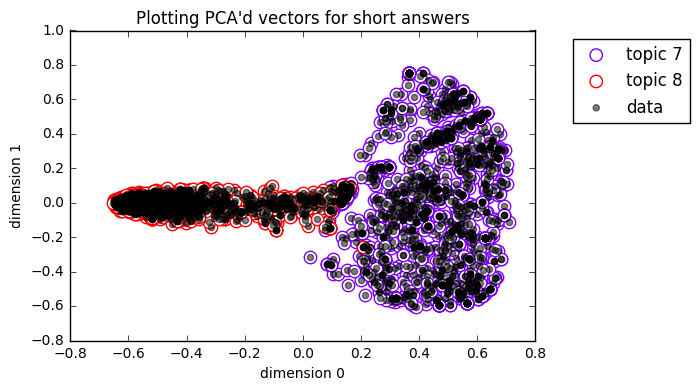

In [624]:
# dim0=3;
# dim1=1;
colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))
#for q in sorted(df_temp.loc[:,'topic'].unique()):

for q in question_subset:
    color=next(colors)
    plt.scatter(df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim0],df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim1],
                edgecolor=color,alpha=1, s=80, facecolor='white',label='topic %s'%q);
#     plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
#                 edgecolor='black', c=color,alpha=.5, label='question %s'%q);


plt.scatter(df_temp.loc[:,dim0],df_temp.loc[:,dim1],
                c='black',alpha=.5,label='data');
plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.35,1))
plt.xlabel('dimension %s'%(dim0))
plt.ylabel('dimension %s'%(dim1))
plt.title("Plotting PCA'd vectors for short answers")
plt.show()

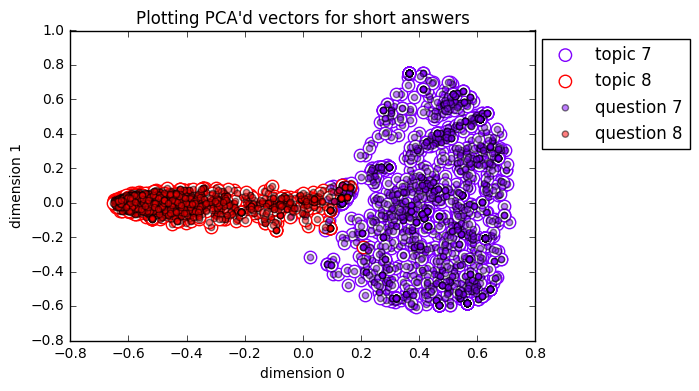

In [625]:
# dim0=0;
# dim1=1;
colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))
#for q in sorted(df_temp.loc[:,'topic'].unique()):
for q in question_subset:
    color=next(colors)
    plt.scatter(df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim0],df_temp.loc[df_temp.loc[:,'topic_conversion']==q,dim1],
                edgecolor=color,alpha=1, s=80, facecolor='white',label='topic %s'%q);
#     plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
#                 edgecolor='black', c=color,alpha=.5, label='question %s'%q);
colors=iter(cm.rainbow(np.linspace(0,1,len(question_subset))))

for q in question_subset:
    color=next(colors)
#     plt.scatter(df_temp.loc[df_temp.loc[:,'prediction']==q,dim0],df_temp.loc[df_temp.loc[:,'prediction']==q,dim1],
#                 edgecolor=color,alpha=1, s=80, facecolor='white',label='question %s'%q);
    plt.scatter(df_temp.loc[df_temp.loc[:,'label']==q,dim0],df_temp.loc[df_temp.loc[:,'label']==q,dim1],
                edgecolor='black', c=color,alpha=.5,label='question %s'%q);
plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.35,1))
plt.xlabel('dimension %s'%(dim0))
plt.ylabel('dimension %s'%(dim1))
plt.title("Plotting PCA'd vectors for short answers")
plt.show()

# All together

In [459]:
questions=[1,2,3,4,5,6,7,8,9,10];
question_subset=[np.random.choice(questions, 1, replace=False)[0]];
questions=[elm for elm in questions if elm not in question_subset]
for j in range(2,11):
    print(question_subset)
    question_subset.append(np.random.choice(questions, 1, replace=False)[0])
    questions=[elm for elm in questions if elm not in question_subset]

[4]
[4, 2]
[4, 2, 8]
[4, 2, 8, 7]
[4, 2, 8, 7, 6]
[4, 2, 8, 7, 6, 10]
[4, 2, 8, 7, 6, 10, 5]
[4, 2, 8, 7, 6, 10, 5, 9]
[4, 2, 8, 7, 6, 10, 5, 9, 1]


In [460]:
BASELINE=[];
SUPERVISED=[];
SUPERVISED_STD=[]
UNSUPERVISED=[];
UNSUPERVISED_STD=[];
questions=[1,2,3,4,5,6,7,8,9,10];
question_subset=[np.random.choice(questions, 1, replace=False)[0]];
questions=[elm for elm in questions if elm not in question_subset]
for j in range(2,11):
    print(j)
    question_subset.append(np.random.choice(questions, 1, replace=False)[0])
    print(question_subset)
    questions=[elm for elm in questions if elm not in question_subset]
    #question_subset=[1,4,7,9,10];
    ngram_range=(1,5);
    max_features=20;
    train_column='EssayText'

    df_q=df_full.loc[(df_full.loc[:,'EssaySet'].isin(question_subset)),:]
    df_q.reset_index(inplace=True)
    del df_q['index']
    baseline=(df_q.loc[:,'EssaySet'].value_counts().values/len(df_q)).max();
    BASELINE.append(np.round(baseline*100,2))
    print('Single solution baseline:', np.round(baseline*100,2),'percent correct')

    df_vector=tfidf(df_q,ngram_range, max_features)

    train_index, test_index=train_test_split(df_vector)

    clf, sv_mean, cv_std, predictions=SVM(df_vector,train_index,test_index)
    SUPERVISED.append(sv_mean)
    SUPERVISED_STD.append(cv_std)
    df_temp=pca(10)
    LDA_stats=[]
    for ii in range(0,10):
        tf, lda, tf_names=LDA('EssayText', 300, len(question_subset))
        df_temp['topics']=np.argmax(lda.transform(tf),axis=1)
        df_temp['topic_conversion']=''
        for t in sorted(df_temp.loc[:,'topics'].unique()):
            label_topic_conversion=df_temp.loc[df_temp.loc[:,'topics']==t,'label'].value_counts().index[0]
            df_temp.loc[df_temp.loc[:,'topics']==t,'topic_conversion']=label_topic_conversion
        percent_correct=np.round((df_temp['label']==df_temp['topic_conversion']).sum()/len(df_temp)*100,2)
        LDA_stats.append(percent_correct)
    LDA_mean=np.round(np.mean(LDA_stats),2)
    LDA_std=np.round(np.std(LDA_stats),2)
    UNSUPERVISED.append(LDA_mean)
    UNSUPERVISED_STD.append(LDA_std)
    print('unsupervised LDA:',LDA_mean, '+/-',LDA_std)

2
[9, 6]
Single solution baseline: 50.01 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 95.41 +/- 1.19
95.13
unsupervised LDA: 93.51 +/- 4.17
3
[9, 6, 10]
Single solution baseline: 34.35 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 96.49 +/- 0.81
95.8
unsupervised LDA: 90.92 +/- 9.57
4
[9, 6, 10, 2]
Single solution baseline: 27.61 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 95.14 +/- 1.0
96.78
unsupervised LDA: 89.19 +/- 7.39
5
[9, 6, 10, 2, 4]
Single solution baseline: 21.79 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 95.76 +/- 0.79
95.58
unsupervised LDA: 85.59 +/- 6.74
6
[9, 6, 10, 2, 4, 8]
Single solution baseline: 17.9 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 93.11 +/- 1.07
93.33
unsupervised LDA: 80.55 +/- 5.6
7
[9, 6, 10, 2, 4, 8, 5]
Single solution baseline: 15.19 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 87.4 +/- 0.72
86.37
unsupervised LDA: 80.33 +/- 4.35
8
[9, 6, 10, 2, 4, 8, 5, 3]
Single solution baseline: 13.77 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 82.67 +/- 1.2
82.1
unsupervised LDA: 76.89 +/- 4.44
9
[9, 6, 10, 2, 4, 8, 5, 3, 7]
Single solution baseline: 12.17 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 82.17 +/- 0.68
81.78
unsupervised LDA: 74.65 +/- 5.06
10
[9, 6, 10, 2, 4, 8, 5, 3, 7, 1]
Single solution baseline: 10.99 percent correct


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


model score: 81.68 +/- 0.85
80.97
unsupervised LDA: 75.18 +/- 4.07


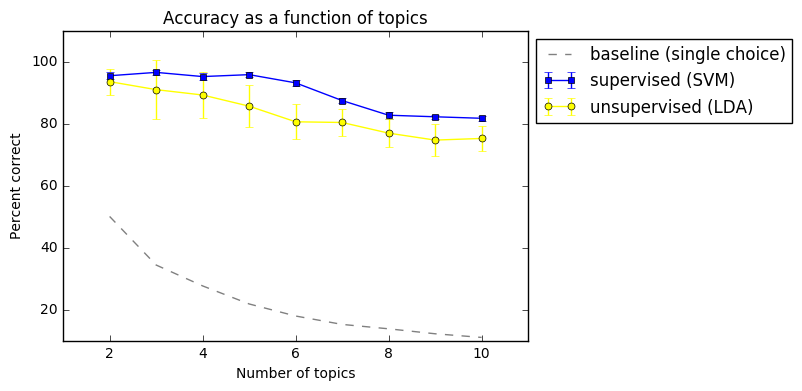

In [561]:
#errorbar(Cs, Ss, yerr=errs, xerr=None)
x_range=range(2,11)
plt.plot(x_range, BASELINE, label='baseline (single choice)', linestyle='--', color='grey')
plt.errorbar(x_range, SUPERVISED, yerr=SUPERVISED_STD, label='supervised (SVM)', color='blue', marker='s', markersize=5)
plt.errorbar(x_range, UNSUPERVISED, yerr=UNSUPERVISED_STD, label='unsupervised (LDA)', color='yellow',marker='o', markersize=5)
plt.title("Accuracy as a function of topics")
plt.xlabel('Number of topics')
plt.ylabel('Percent correct')
plt.legend(scatterpoints=1,loc=0, bbox_to_anchor=(1.,1))
plt.xlim([1,11])
plt.show()